In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input, Dropout, AveragePooling2D
from tensorflow.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# Set the random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load images
image1 = cv2.imread('/content/set11.tif', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('/content/set12.tif', cv2.IMREAD_GRAYSCALE)
ground_truth = cv2.imread('/content/gt1.tif', cv2.IMREAD_GRAYSCALE)

# Check if the images are loaded properly
if image1 is None or image2 is None or ground_truth is None:
    raise ValueError("One or more images could not be loaded. Please check the file paths.")

# Pad width
pad_width = 2

# Pad images
image1_padded = np.pad(image1, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant')
image2_padded = np.pad(image2, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant')

# Function to get neighborhood
def get_neighbourhood(image_padded, i, j):
    return image_padded[i - pad_width:i + pad_width + 1, j - pad_width:j + pad_width + 1].reshape(5, 5, 1)  # Reshape to 5x5x1 for CNN input

# Prepare data
data = []
labels = []
for i in range(pad_width, image1_padded.shape[0] - pad_width):
    for j in range(pad_width, image1_padded.shape[1] - pad_width):
        neighbourhood1 = get_neighbourhood(image1_padded, i, j)
        neighbourhood2 = get_neighbourhood(image2_padded, i, j)
        data.append(np.dstack((neighbourhood1, neighbourhood2)))  # Stack the two neighborhoods to create a 5x5x2 input

# Convert data to a numpy array
data = np.array(data)

# Get change locations from ground truth
change_indices = np.argwhere(ground_truth == 0)
unchanged_indices = np.argwhere(ground_truth != 0)

# Ensure we have enough samples
if len(change_indices) < 150 or len(unchanged_indices) < 150:
    raise ValueError("Not enough change or unchanged locations in the ground truth image.")

# Randomly select 150 change and unchanged locations
selected_change_indices = np.random.choice(len(change_indices), size=150, replace=False)
selected_unchanged_indices = np.random.choice(len(unchanged_indices), size=150, replace=False)

# Extract samples and labels
change_samples = [data[(i - pad_width) * (image1_padded.shape[1] - 2 * pad_width) + (j - pad_width)] for i, j in change_indices[selected_change_indices]]
unchanged_samples = [data[(i - pad_width) * (image1_padded.shape[1] - 2 * pad_width) + (j - pad_width)] for i, j in unchanged_indices[selected_unchanged_indices]]

change_labels = [0] * 150
unchanged_labels = [1] * 150

# Combine data
X = np.array(change_samples + unchanged_samples)
y = np.array(change_labels + unchanged_labels)

# Reshape y to be a 1D array (for binary classification)
y = y.reshape(-1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the U-Net model with ASPP module for binary classification
def unet_model(input_shape=(5, 5, 2)):
    inputs = Input(input_shape)

    # Contracting path (Encoder)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((1, 1))(conv1)  # Changed pool size to (1, 1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((1, 1))(conv2)  # Changed pool size to (1, 1)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    # Removed MaxPooling layer

    # Bottleneck with ASPP module
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)

    # ASPP module: apply different dilations
    aspp_1 = Conv2D(256, (3, 3), dilation_rate=1, activation='relu', padding='same')(conv4)
    aspp_2 = Conv2D(256, (3, 3), dilation_rate=2, activation='relu', padding='same')(conv4)
    aspp_3 = Conv2D(256, (3, 3), dilation_rate=4, activation='relu', padding='same')(conv4)
    aspp_4 = Conv2D(256, (3, 3), dilation_rate=8, activation='relu', padding='same')(conv4)

    # Concatenate ASPP outputs
    aspp_out = Concatenate()([aspp_1, aspp_2, aspp_3, aspp_4])
    aspp_out = Conv2D(256, (1, 1), activation='relu', padding='same')(aspp_out)

    # Expanding path (Decoder)
    up5 = Conv2D(128, (3, 3), activation='relu', padding='same')(aspp_out)
    concat5 = Concatenate()([up5, conv3])  # Ensure shapes are compatible
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    up6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    concat6 = Concatenate()([up6, conv2])  # Ensure shapes are compatible
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv6)
    concat7 = Concatenate()([up7, conv1])  # Ensure shapes are compatible
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)

    output = tf.keras.layers.Flatten()(conv7)  # Flatten the output from the previous layer
    output = tf.keras.layers.Dense(1, activation='sigmoid')(output)  # Add a Dense layer with a single output and sigmoid activation

    # Create the model
    model = Model(inputs, output)
    return model

# Create the model
model = unet_model()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Extract TP, TN, FP, FN
TN, FP, FN, TP = cm.ravel()

# Calculate N0 and N1
N0 = TP + FN  # Total number of changed pixels
N1 = TN + FP  # Total number of unchanged pixels

# Calculate metrics
PCC = ((TP + TN) / (N0 + N1)) * 100 if (N0 + N1) != 0 else 0
PFA = FP / N1 if N1 != 0 else 0
PTE = (FP + FN) / (N0 + N1) if (N0 + N1) != 0 else 0

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)

# Print the results
print(f"Model accuracy on test set: {accuracy:.2f}")
print(f"Correct Classification (CC): {TP + TN}")
print(f"False Alarms (FA): {FP}")
print(f"Total Error (TE): {FP + FN}")
print(f"Probabilistic Conditional Correctness (PCC): {PCC:.2f}%")
print(f"Probability of False Alarm (PFA): {PFA:.2f}")
print(f"Probability of Total Error (PTE): {PTE:.2f}")

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 583ms/step - accuracy: 0.6082 - loss: 0.8393 - val_accuracy: 0.8556 - val_loss: 0.3948
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7989 - loss: 0.4786 - val_accuracy: 0.8333 - val_loss: 0.4505
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8366 - loss: 0.3920 - val_accuracy: 0.8556 - val_loss: 0.3826
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8995 - loss: 0.3044 - val_accuracy: 0.9000 - val_loss: 0.3260
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9173 - loss: 0.2428 - val_accuracy: 0.9000 - val_loss: 0.3096
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9477 - loss: 0.1901 - val_accuracy: 0.8778 - val_loss: 0.3147
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9262 - loss: 0.1791 - val_accuracy: 0.9000 - val_loss: 0.3028
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9591 - loss: 0.1240 - val_accuracy: 0.8778 -

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


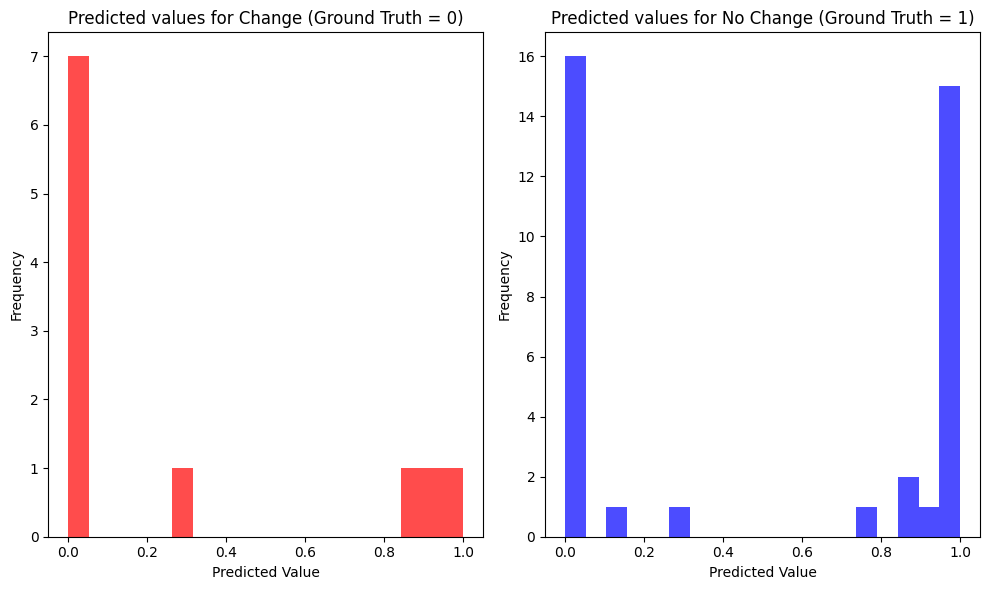

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load the ground truth and predicted values (for this example, we're assuming you have the predictions from your trained model)
# Make sure you load the ground truth and predicted values as required
ground_truth = cv2.imread('/content/gt1.tif', cv2.IMREAD_GRAYSCALE)
y_pred_classes = model.predict(X_test)  # Assuming you've trained your model and have predictions from the test set
#y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Get the indices where ground truth is 0 (change) and 1 (no change)
# Use ground_truth corresponding to the test set
ground_truth_test = ground_truth.flatten()[np.argwhere(y_test.flatten() == 0)]
#ground_truth_test = ground_truth.flatten()[np.argwhere(y_test.flatten() == 1)]

change_indices = np.where(ground_truth_test == 0)[0]  # Ground truth is 0 (change)
unchanged_indices = np.where(ground_truth_test == 255)[0]  # Ground truth is 1 (no change)

# Extract the predicted values for the change (0) and unchanged (1) locations
pred_change = y_pred_classes[change_indices]
pred_unchanged = y_pred_classes[unchanged_indices]

# Plot the results
plt.figure(figsize=(10, 6))

# Plot predicted values for 'change' (ground truth = 0)
plt.subplot(1, 2, 1)
plt.hist(pred_change, bins=np.linspace(0, 1, 20), color='red', alpha=0.7)
plt.title("Predicted values for Change (Ground Truth = 0)")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")

# Plot predicted values for 'no change' (ground truth = 1)
plt.subplot(1, 2, 2)
plt.hist(pred_unchanged, bins=np.linspace(0, 1, 20), color='blue', alpha=0.7)
plt.title("Predicted values for No Change (Ground Truth = 1)")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dense, Flatten, Lambda, Multiply, Add

def attention_gate(x, g, inter_channels):
    """Attention Gate: Takes input (x), gating signal (g), and intermediate channels."""
    theta_x = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(x)  # Transform input x
    phi_g = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(g)  # Transform gating signal

    add_xg = Add()([theta_x, phi_g])  # Add transformed inputs
    relu_xg = tf.keras.layers.Activation('relu')(add_xg)  # Apply ReLU

    psi = Conv2D(1, kernel_size=1, strides=1, padding='same', activation='sigmoid')(relu_xg)  # Output gating signal

    return Multiply()([x, psi])  # Multiply input with attention mask

def unet_with_attention(input_shape=(5, 5, 2)):
    inputs = Input(input_shape)

    # Contracting Path (Encoder)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((1, 1))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((1, 1))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

    # Bottleneck with ASPP Module
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)

    aspp_1 = Conv2D(256, (3, 3), dilation_rate=1, activation='relu', padding='same')(conv4)
    aspp_2 = Conv2D(256, (3, 3), dilation_rate=2, activation='relu', padding='same')(conv4)
    aspp_3 = Conv2D(256, (3, 3), dilation_rate=4, activation='relu', padding='same')(conv4)
    aspp_4 = Conv2D(256, (3, 3), dilation_rate=8, activation='relu', padding='same')(conv4)

    aspp_out = Concatenate()([aspp_1, aspp_2, aspp_3, aspp_4])
    aspp_out = Conv2D(256, (1, 1), activation='relu', padding='same')(aspp_out)

    # Expanding Path (Decoder) with Attention Gates
    up5 = UpSampling2D((1, 1))(aspp_out)
    att5 = attention_gate(conv3, up5, inter_channels=128)
    concat5 = Concatenate()([up5, att5])
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    up6 = UpSampling2D((1, 1))(conv5)
    att6 = attention_gate(conv2, up6, inter_channels=64)
    concat6 = Concatenate()([up6, att6])
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D((1, 1))(conv6)
    att7 = attention_gate(conv1, up7, inter_channels=32)
    concat7 = Concatenate()([up7, att7])
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)

    output = Flatten()(conv7)
    output = Dense(1, activation='sigmoid')(output)

    model = Model(inputs, output)
    return model

# Create the model
model = unet_with_attention()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Predict and Evaluate
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Confusion Matrix and Metrics
cm = confusion_matrix(y_test, y_pred_classes)
TN, FP, FN, TP = cm.ravel()
N0 = TP + FN
N1 = TN + FP
PCC = ((TP + TN) / (N0 + N1)) * 100 if (N0 + N1) != 0 else 0
PFA = FP / N1 if N1 != 0 else 0
PTE = (FP + FN) / (N0 + N1) if (N0 + N1) != 0 else 0
accuracy = accuracy_score(y_test, y_pred_classes)

# Print Results
print(f"Model accuracy on test set: {accuracy:.2f}")
print(f"Correct Classification (CC): {TP + TN}")
print(f"False Alarms (FA): {FP}")
print(f"Total Error (TE): {FP + FN}")
print(f"Probabilistic Conditional Correctness (PCC): {PCC:.2f}%")
print(f"Probability of False Alarm (PFA): {PFA:.2f}")
print(f"Probability of Total Error (PTE): {PTE:.2f}")


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 635ms/step - accuracy: 0.5798 - loss: 1.3579 - val_accuracy: 0.5333 - val_loss: 0.8179
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7488 - loss: 0.5178 - val_accuracy: 0.8778 - val_loss: 0.3043
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8062 - loss: 0.4388 - val_accuracy: 0.9000 - val_loss: 0.3342
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8799 - loss: 0.3258 - val_accuracy: 0.8333 - val_loss: 0.4667
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8709 - loss: 0.3615 - val_accuracy: 0.7667 - val_loss: 0.5318
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8526 - loss: 0.3984 - val_accuracy: 0.8444 - val_loss: 0.5167
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8837 - loss: 0.3624 - val_accuracy: 0.8778 - val_loss: 0.4286
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9060 - loss: 0.3309 - val_accuracy: 0.9000 -

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


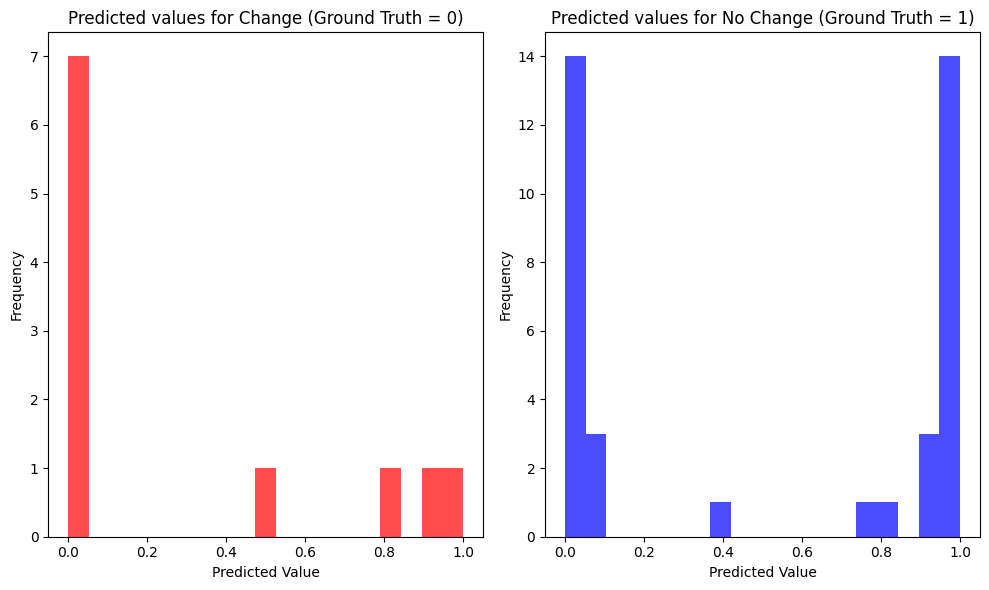

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load the ground truth and predicted values (for this example, we're assuming you have the predictions from your trained model)
# Make sure you load the ground truth and predicted values as required
ground_truth = cv2.imread('/content/gt1.tif', cv2.IMREAD_GRAYSCALE)
y_pred_classes = model.predict(X_test)  # Assuming you've trained your model and have predictions from the test set
#y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Get the indices where ground truth is 0 (change) and 1 (no change)
# Use ground_truth corresponding to the test set
ground_truth_test = ground_truth.flatten()[np.argwhere(y_test.flatten() == 0)]
#ground_truth_test = ground_truth.flatten()[np.argwhere(y_test.flatten() == 1)]

change_indices = np.where(ground_truth_test == 0)[0]  # Ground truth is 0 (change)
unchanged_indices = np.where(ground_truth_test == 255)[0]  # Ground truth is 1 (no change)

# Extract the predicted values for the change (0) and unchanged (1) locations
pred_change = y_pred_classes[change_indices]
pred_unchanged = y_pred_classes[unchanged_indices]

# Plot the results
plt.figure(figsize=(10, 6))

# Plot predicted values for 'change' (ground truth = 0)
plt.subplot(1, 2, 1)
plt.hist(pred_change, bins=np.linspace(0, 1, 20), color='red', alpha=0.7)
plt.title("Predicted values for Change (Ground Truth = 0)")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")

# Plot predicted values for 'no change' (ground truth = 1)
plt.subplot(1, 2, 2)
plt.hist(pred_unchanged, bins=np.linspace(0, 1, 20), color='blue', alpha=0.7)
plt.title("Predicted values for No Change (Ground Truth = 1)")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [ ]:
TN, FP, FN, TP

(46, 2, 6, 36)

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dense, Flatten, Lambda, Multiply, Add
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load images
image1 = cv2.imread('/content/set11.tif', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('/content/set12.tif', cv2.IMREAD_GRAYSCALE)
ground_truth = cv2.imread('/content/gt1.tif', cv2.IMREAD_GRAYSCALE)

# Pad images and check if images are loaded properly
pad_width = 2
image1_padded = np.pad(image1, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant')
image2_padded = np.pad(image2, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant')

# Function to get neighborhood
def get_neighbourhood(image_padded, i, j):
    return image_padded[i - pad_width:i + pad_width + 1, j - pad_width:j + pad_width + 1].reshape(5, 5, 1)

# Prepare data
data = []
labels = []
for i in range(pad_width, image1_padded.shape[0] - pad_width):
    for j in range(pad_width, image1_padded.shape[1] - pad_width):
        neighbourhood1 = get_neighbourhood(image1_padded, i, j)
        neighbourhood2 = get_neighbourhood(image2_padded, i, j)
        data.append(np.dstack((neighbourhood1, neighbourhood2)))  # Stack the two neighborhoods

# Convert data to numpy array
data = np.array(data)

# Get change locations from ground truth
change_indices = np.argwhere(ground_truth == 0)
unchanged_indices = np.argwhere(ground_truth != 0)

# Ensure we have enough samples
if len(change_indices) < 150 or len(unchanged_indices) < 150:
    raise ValueError("Not enough change or unchanged locations in the ground truth image.")

# Randomly select 150 change and unchanged locations
selected_change_indices = np.random.choice(len(change_indices), size=150, replace=False)
selected_unchanged_indices = np.random.choice(len(unchanged_indices), size=150, replace=False)

# Extract samples and labels
change_samples = [data[(i - pad_width) * (image1_padded.shape[1] - 2 * pad_width) + (j - pad_width)] for i, j in change_indices[selected_change_indices]]
unchanged_samples = [data[(i - pad_width) * (image1_padded.shape[1] - 2 * pad_width) + (j - pad_width)] for i, j in unchanged_indices[selected_unchanged_indices]]

change_labels = [0] * 150
unchanged_labels = [1] * 150

# Combine data
X = np.array(change_samples + unchanged_samples)
y = np.array(change_labels + unchanged_labels)

# Reshape y to be a 1D array for binary classification
y = y.reshape(-1)

# Cross-validation setup using KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Define U-Net with Attention model
def attention_gate(x, g, inter_channels):
    theta_x = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(x)
    phi_g = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(g)
    add_xg = Add()([theta_x, phi_g])
    relu_xg = tf.keras.layers.Activation('relu')(add_xg)
    psi = Conv2D(1, kernel_size=1, strides=1, padding='same', activation='sigmoid')(relu_xg)
    return Multiply()([x, psi])

def unet_with_attention(input_shape=(5, 5, 2)):
    inputs = Input(input_shape)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((1, 1))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((1, 1))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)

    aspp_1 = Conv2D(256, (3, 3), dilation_rate=1, activation='relu', padding='same')(conv4)
    aspp_2 = Conv2D(256, (3, 3), dilation_rate=2, activation='relu', padding='same')(conv4)
    aspp_3 = Conv2D(256, (3, 3), dilation_rate=4, activation='relu', padding='same')(conv4)
    aspp_4 = Conv2D(256, (3, 3), dilation_rate=8, activation='relu', padding='same')(conv4)
    aspp_out = Concatenate()([aspp_1, aspp_2, aspp_3, aspp_4])
    aspp_out = Conv2D(256, (1, 1), activation='relu', padding='same')(aspp_out)

    up5 = UpSampling2D((1, 1))(aspp_out)
    att5 = attention_gate(conv3, up5, inter_channels=128)
    concat5 = Concatenate()([up5, att5])
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    up6 = UpSampling2D((1, 1))(conv5)
    att6 = attention_gate(conv2, up6, inter_channels=64)
    concat6 = Concatenate()([up6, att6])
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D((1, 1))(conv6)
    att7 = attention_gate(conv1, up7, inter_channels=32)
    concat7 = Concatenate()([up7, att7])
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)

    output = Flatten()(conv7)
    output = Dense(1, activation='sigmoid')(output)
    model = Model(inputs, output)
    return model

# Cross-validation loop
accuracies = []
for train_index, val_index in kf.split(X):
    # Split data into train and validation based on current fold
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Data augmentation (can be added to your training loop)
    datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)
    datagen.fit(X_train_fold)

    # Create and compile the model for each fold
    model = unet_with_attention(input_shape=(5, 5, 2))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(datagen.flow(X_train_fold, y_train_fold, batch_size=16), epochs=20, validation_data=(X_val_fold, y_val_fold))

    # Predict and evaluate
    y_pred_fold = model.predict(X_val_fold)
    y_pred_classes_fold = (y_pred_fold > 0.5).astype(int).flatten()

    # Calculate confusion matrix
    cm = confusion_matrix(y_val_fold, y_pred_classes_fold)
    TN, FP, FN, TP = cm.ravel()

    # Calculate metrics
    N0 = TP + FN
    N1 = TN + FP
    PCC = ((TP + TN) / (N0 + N1)) * 100 if (N0 + N1) != 0 else 0
    PFA = FP / N1 if N1 != 0 else 0
    PTE = (FP + FN) / (N0 + N1) if (N0 + N1) != 0 else 0
    accuracy_fold = accuracy_score(y_val_fold, y_pred_classes_fold)

    # Store metrics
    accuracies.append(accuracy_fold)

    # Print metrics for each fold
    print(f"Fold Accuracy: {accuracy_fold:.2f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Correct Classification (CC): {TP + TN}")
    print(f"False Alarms (FA): {FP}")
    print(f"Total Error (TE): {FP + FN}")
    print(f"Probabilistic Conditional Correctness (PCC): {PCC:.2f}%")
    print(f"Probability of False Alarm (PFA): {PFA:.2f}")
    print(f"Probability of Total Error (PTE): {PTE:.2f}")
    print("-" * 50)

# Print average accuracy over all folds
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy over 5 folds: {average_accuracy:.2f}")


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1495: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (240, 5, 5, 2) (2 channels).
  warnings.warn(


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (240, 5, 5, 2) (2 channels).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - accuracy: 0.5498 - loss: 0.7508 - val_accuracy: 0.6667 - val_loss: 0.6313
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6189 - loss: 0.6102 - val_accuracy: 0.5833 - val_loss: 0.6369
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6769 - loss: 0.6127 - val_accuracy: 0.8000 - val_loss: 0.5124
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7540 - loss: 0.5362 - val_accuracy: 0.8500 - val_loss: 0.4461
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8019 - loss: 0.5140 - val_accuracy: 0.8000 - val_loss: 0.5094
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6777 - loss: 0.5508 - val_accuracy: 0.8000 - val_loss: 0.4571
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7835 - loss: 0.4364 - val_accuracy: 0.9000 - val_loss: 0.4132
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8447 - loss: 0.4046 - val_accuracy: 0.9000 - val_loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1495: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (240, 5, 5, 2) (2 channels).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (240, 5, 5, 2) (2 channels).
  warnings.warn(


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.7113 - loss: 0.7332 - val_accuracy: 0.7833 - val_loss: 0.4347
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8752 - loss: 0.3435 - val_accuracy: 0.7833 - val_loss: 0.4617
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8842 - loss: 0.2446 - val_accuracy: 0.8167 - val_loss: 0.3813
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9171 - loss: 0.2036 - val_accuracy: 0.9000 - val_loss: 0.3372
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8874 - loss: 0.3203 - val_accuracy: 0.9000 - val_loss: 0.2945
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9291 - loss: 0.2210 - val_accuracy: 0.8833 - val_loss: 0.3306
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9386 - loss: 0.1841 - val_accuracy: 0.8833 - val_loss: 0.3386
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9230 - loss: 0.1675 - val_accuracy: 0.8667 - val_loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1495: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (240, 5, 5, 2) (2 channels).
  warnings.warn(


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (240, 5, 5, 2) (2 channels).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.5597 - loss: 1.5267 - val_accuracy: 0.8667 - val_loss: 0.4313
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8334 - loss: 0.4440 - val_accuracy: 0.8833 - val_loss: 0.3106
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8761 - loss: 0.3401 - val_accuracy: 0.8333 - val_loss: 0.3637
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8895 - loss: 0.2739 - val_accuracy: 0.8667 - val_loss: 0.3158
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9129 - loss: 0.2388 - val_accuracy: 0.8333 - val_loss: 0.4336
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8940 - loss: 0.2367 - val_accuracy: 0.8833 - val_loss: 0.3715
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9512 - loss: 0.1912 - val_accuracy: 0.8333 - val_loss: 0.3769
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8920 - loss: 0.3244 - val_accuracy: 0.8667 - val_loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1495: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (240, 5, 5, 2) (2 channels).
  warnings.warn(


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (240, 5, 5, 2) (2 channels).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.4339 - loss: 0.8094 - val_accuracy: 0.7167 - val_loss: 0.5935
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7732 - loss: 0.5630 - val_accuracy: 0.8333 - val_loss: 0.3809
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8354 - loss: 0.4361 - val_accuracy: 0.8667 - val_loss: 0.3067
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8427 - loss: 0.3718 - val_accuracy: 0.9333 - val_loss: 0.2165
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8487 - loss: 0.3324 - val_accuracy: 0.8667 - val_loss: 0.3610
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8641 - loss: 0.3934 - val_accuracy: 0.9167 - val_loss: 0.2470
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9324 - loss: 0.2437 - val_accuracy: 0.9333 - val_loss: 0.2462
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9159 - loss: 0.2753 - val_accuracy: 0.8667 - val_loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1495: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (240, 5, 5, 2) (2 channels).
  warnings.warn(


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (240, 5, 5, 2) (2 channels).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.5036 - loss: 0.7437 - val_accuracy: 0.9167 - val_loss: 0.5343
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8576 - loss: 0.4696 - val_accuracy: 0.9167 - val_loss: 0.2321
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8684 - loss: 0.2932 - val_accuracy: 0.9333 - val_loss: 0.2600
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8774 - loss: 0.2859 - val_accuracy: 0.9500 - val_loss: 0.1859
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9110 - loss: 0.2769 - val_accuracy: 0.8500 - val_loss: 0.3785
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8567 - loss: 0.3266 - val_accuracy: 0.9333 - val_loss: 0.1548
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8622 - loss: 0.2742 - val_accuracy: 0.9667 - val_loss: 0.1687
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9147 - loss: 0.2210 - val_accuracy: 0.9667 - val_loss: 

### **Final Code**

Epoch 1/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 126s 14ms/step - accuracy: 0.9722 - loss: 0.0937
Epoch 2/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 131s 14ms/step - accuracy: 0.9799 - loss: 0.0557
Epoch 3/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 140s 14ms/step - accuracy: 0.9811 - loss: 0.0578
Epoch 4/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 144s 14ms/step - accuracy: 0.9827 - loss: 0.0469
Epoch 5/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 140s 14ms/step - accuracy: 0.9840 - loss: 0.0434
Epoch 6/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 142s 14ms/step - accuracy: 0.9841 - loss: 0.0421
Epoch 7/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 142s 14ms/step - accuracy: 0.9843 - loss: 0.0412
Epoch 8/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 142s 14ms/step - accuracy: 0.9849 - loss: 0.0386
Epoch 9/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 142s 14ms/step - accuracy: 0.9855 - loss: 0.0381
Epoch 10/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 105s 14ms/step - accuracy: 0.9853 - loss: 0.0381
Epoch 11/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 108s 14ms/step - accuracy: 0.9855 - loss: 0.03

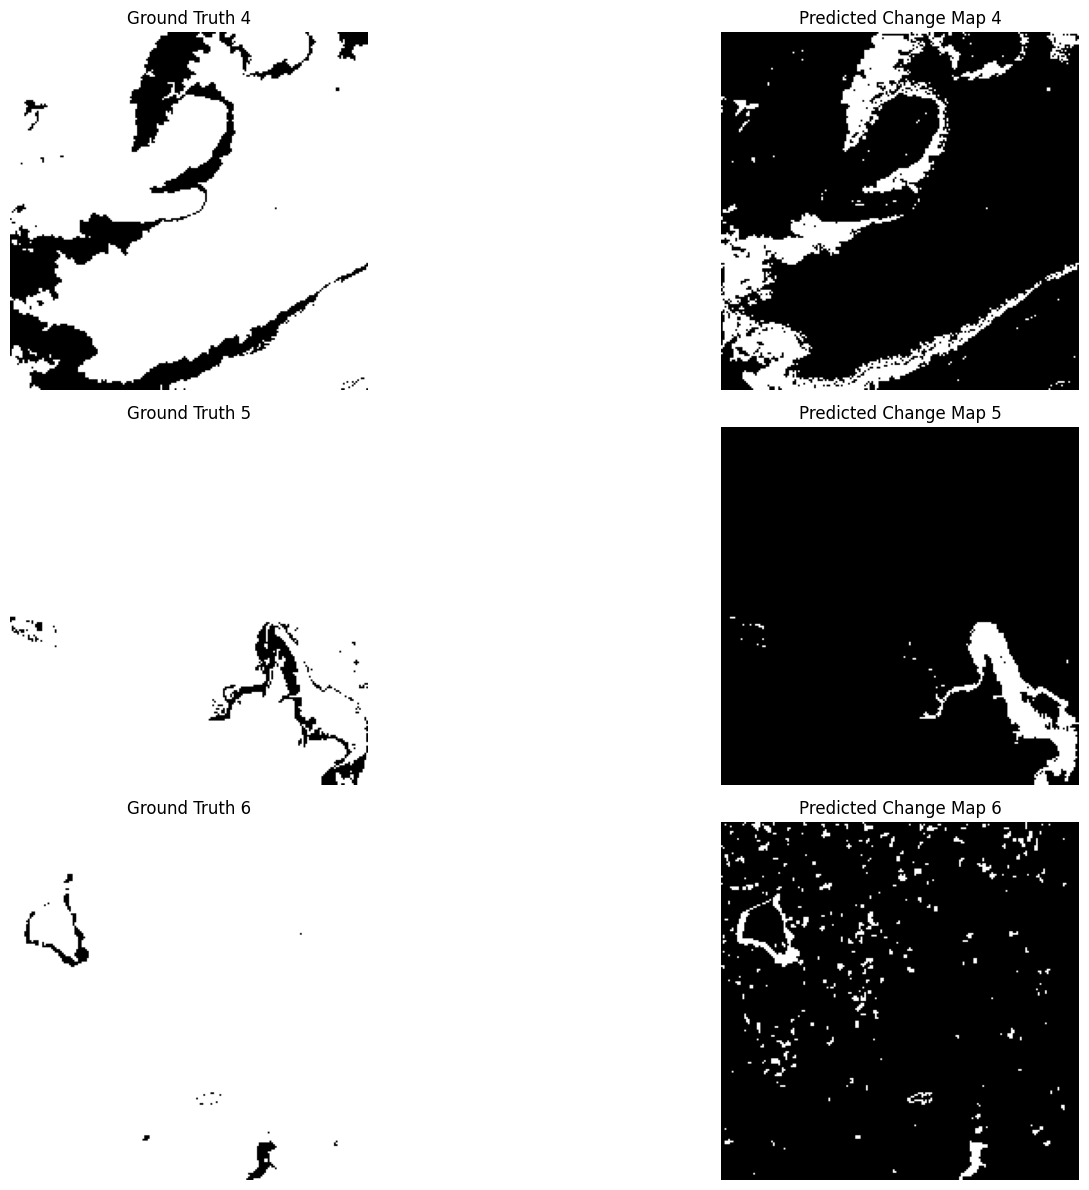

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dense, Flatten, Multiply, Add

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Helper function to load and pad images
def load_and_pad_image(filepath, pad_width):
    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    return np.pad(image, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant')

# Function to get neighborhood
def get_neighbourhood(image_padded, i, j, pad_width):
    return image_padded[i - pad_width:i + pad_width + 1, j - pad_width:j + pad_width + 1].reshape(5, 5, 1)

# Function to prepare data for a given dataset
def prepare_data(image1, image2, ground_truth, pad_width):
    image1_padded = load_and_pad_image(image1, pad_width)
    image2_padded = load_and_pad_image(image2, pad_width)
    ground_truth = cv2.imread(ground_truth, cv2.IMREAD_GRAYSCALE)

    data = []
    labels = []
    for i in range(pad_width, image1_padded.shape[0] - pad_width):
        for j in range(pad_width, image1_padded.shape[1] - pad_width):
            neighbourhood1 = get_neighbourhood(image1_padded, i, j, pad_width)
            neighbourhood2 = get_neighbourhood(image2_padded, i, j, pad_width)
            data.append(np.dstack((neighbourhood1, neighbourhood2)))
            labels.append(1 if ground_truth[i - pad_width, j - pad_width] == 0 else 0)

    return np.array(data), np.array(labels), ground_truth

# Define U-Net with Attention model
def attention_gate(x, g, inter_channels):
    theta_x = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(x)
    phi_g = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(g)
    add_xg = Add()([theta_x, phi_g])
    relu_xg = tf.keras.layers.Activation('relu')(add_xg)
    psi = Conv2D(1, kernel_size=1, strides=1, padding='same', activation='sigmoid')(relu_xg)
    return Multiply()([x, psi])

def unet_with_attention(input_shape=(5, 5, 2)):
    inputs = Input(input_shape)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((1, 1))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((1, 1))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)

    aspp_1 = Conv2D(256, (3, 3), dilation_rate=1, activation='relu', padding='same')(conv4)
    aspp_2 = Conv2D(256, (3, 3), dilation_rate=2, activation='relu', padding='same')(conv4)
    aspp_3 = Conv2D(256, (3, 3), dilation_rate=4, activation='relu', padding='same')(conv4)
    aspp_4 = Conv2D(256, (3, 3), dilation_rate=8, activation='relu', padding='same')(conv4)
    aspp_out = Concatenate()([aspp_1, aspp_2, aspp_3, aspp_4])
    aspp_out = Conv2D(256, (1, 1), activation='relu', padding='same')(aspp_out)

    up5 = UpSampling2D((1, 1))(aspp_out)
    att5 = attention_gate(conv3, up5, inter_channels=128)
    concat5 = Concatenate()([up5, att5])
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    up6 = UpSampling2D((1, 1))(conv5)
    att6 = attention_gate(conv2, up6, inter_channels=64)
    concat6 = Concatenate()([up6, att6])
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D((1, 1))(conv6)
    att7 = attention_gate(conv1, up7, inter_channels=32)
    concat7 = Concatenate()([up7, att7])
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)

    output = Flatten()(conv7)
    output = Dense(1, activation='sigmoid')(output)
    model = Model(inputs, output)
    return model

# Define datasets
datasets = [
    ("/content/set11.tif", "/content/set12.tif", "/content/gt1.tif"),
    ("/content/set21.tif", "/content/set22.tif", "/content/gt2.tif"),
    ("/content/set31.tif", "/content/set32.tif", "/content/gt3.tif"),
    ("/content/set41.tif", "/content/set42.tif", "/content/gt4.tif"),
    ("/content/set51.tif", "/content/set52.tif", "/content/gt5.tif"),
    ("/content/set61.tif", "/content/set62.tif", "/content/gt6.tif")
]

# Split datasets into training and testing sets
train_datasets = datasets[:3]
test_datasets = datasets[3:]

# Prepare training data
pad_width = 2
X_train, y_train = [], []

for img1_path, img2_path, gt_path in train_datasets:
    data, labels, _ = prepare_data(img1_path, img2_path, gt_path, pad_width)
    X_train.append(data)
    y_train.append(labels)

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

# Prepare testing data
X_test, y_test, ground_truths = [], [], []

for img1_path, img2_path, gt_path in test_datasets:
    data, labels, ground_truth = prepare_data(img1_path, img2_path, gt_path, pad_width)
    X_test.append(data)
    y_test.append(labels)
    ground_truths.append(ground_truth)

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

# Build and train the model
model = unet_with_attention(input_shape=(5, 5, 2))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1)

# Predict and generate maps
predictions = model.predict(X_test)
predicted_maps = (predictions > 0.5).astype(int)

# Visualization
plt.figure(figsize=(18, 12))
for idx, gt in enumerate(ground_truths):
    plt.subplot(len(ground_truths), 2, 2 * idx + 1)
    plt.imshow(gt, cmap='gray')
    plt.title(f"Ground Truth {idx + 4}")
    plt.axis("off")

    predicted_map = predicted_maps[idx * gt.size:(idx + 1) * gt.size].reshape(gt.shape)
    plt.subplot(len(ground_truths), 2, 2 * idx + 2)
    plt.imshow(predicted_map, cmap='gray')
    plt.title(f"Predicted Change Map {idx + 4}")
    plt.axis("off")

plt.tight_layout()
plt.show()


Epoch 1/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 142s 16ms/step - accuracy: 0.9746 - loss: 0.0687
Epoch 2/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 131s 16ms/step - accuracy: 0.9844 - loss: 0.0417
Epoch 3/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 142s 16ms/step - accuracy: 0.9864 - loss: 0.0358
Epoch 4/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 121s 16ms/step - accuracy: 0.9874 - loss: 0.0322
Epoch 5/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 142s 16ms/step - accuracy: 0.9887 - loss: 0.0298
Epoch 6/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 140s 16ms/step - accuracy: 0.9893 - loss: 0.0278
Epoch 7/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 143s 16ms/step - accuracy: 0.9895 - loss: 0.0261
Epoch 8/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 142s 16ms/step - accuracy: 0.9905 - loss: 0.0246
Epoch 9/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 142s 16ms/step - accuracy: 0.9911 - loss: 0.0233
Epoch 10/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 142s 16ms/step - accuracy: 0.9913 - loss: 0.0222
Epoch 11/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 143s 16ms/step - accuracy: 0.9921 - loss: 0.02

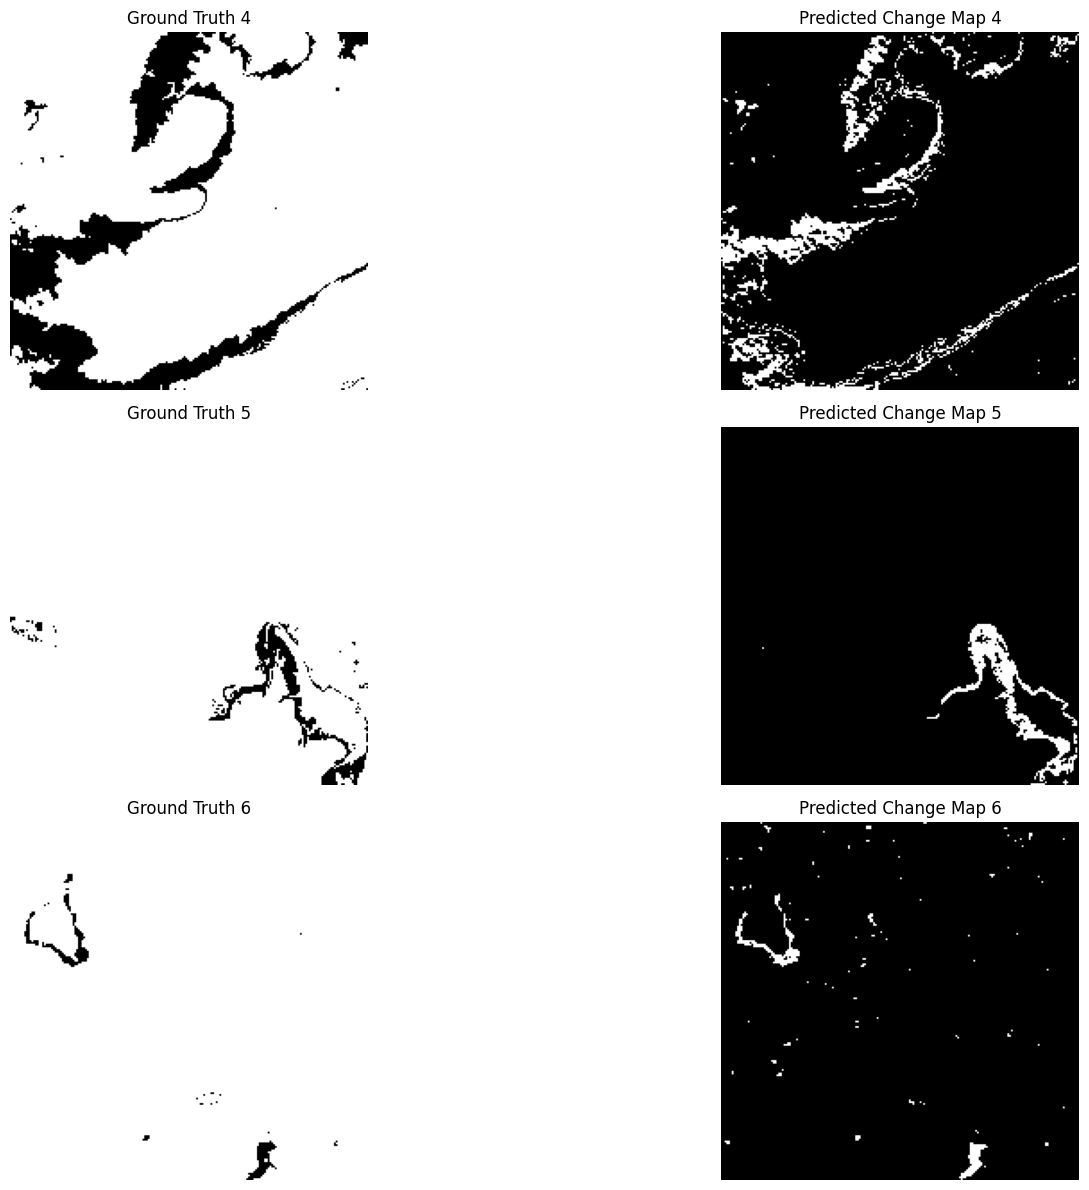

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dense, Flatten, Multiply, Add, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Helper function to load and pad images
def load_and_pad_image(filepath, pad_width):
    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    return np.pad(image, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant')

# Function to get neighborhood
def get_neighbourhood(image_padded, i, j, pad_width):
    return image_padded[i - pad_width:i + pad_width + 1, j - pad_width:j + pad_width + 1].reshape(5, 5, 1)

# Function to prepare data for a given dataset
def prepare_data(image1, image2, ground_truth, pad_width):
    image1_padded = load_and_pad_image(image1, pad_width)
    image2_padded = load_and_pad_image(image2, pad_width)
    ground_truth = cv2.imread(ground_truth, cv2.IMREAD_GRAYSCALE)

    data = []
    labels = []
    for i in range(pad_width, image1_padded.shape[0] - pad_width):
        for j in range(pad_width, image1_padded.shape[1] - pad_width):
            neighbourhood1 = get_neighbourhood(image1_padded, i, j, pad_width)
            neighbourhood2 = get_neighbourhood(image2_padded, i, j, pad_width)
            data.append(np.dstack((neighbourhood1, neighbourhood2)))
            labels.append(1 if ground_truth[i - pad_width, j - pad_width] == 0 else 0)

    return np.array(data), np.array(labels), ground_truth

# Define attention gate
def attention_gate(x, g, inter_channels):
    theta_x = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(x)
    phi_g = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(g)
    add_xg = Add()([theta_x, phi_g])
    relu_xg = tf.keras.layers.Activation('relu')(add_xg)
    psi = Conv2D(1, kernel_size=1, strides=1, padding='same', activation='sigmoid')(relu_xg)
    return Multiply()([x, psi])

# Define U-Net with attention model
def unet_with_attention(input_shape=(5, 5, 2)):
    inputs = Input(input_shape)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((1, 1))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((1, 1))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    aspp_1 = Conv2D(256, (3, 3), dilation_rate=1, activation='relu', padding='same')(conv4)
    aspp_2 = Conv2D(256, (3, 3), dilation_rate=2, activation='relu', padding='same')(conv4)
    aspp_3 = Conv2D(256, (3, 3), dilation_rate=4, activation='relu', padding='same')(conv4)
    aspp_4 = Conv2D(256, (3, 3), dilation_rate=8, activation='relu', padding='same')(conv4)
    aspp_out = Concatenate()([aspp_1, aspp_2, aspp_3, aspp_4])
    aspp_out = Conv2D(256, (1, 1), activation='relu', padding='same')(aspp_out)

    up5 = UpSampling2D((1, 1))(aspp_out)
    att5 = attention_gate(conv3, up5, inter_channels=128)
    concat5 = Concatenate()([up5, att5])
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = UpSampling2D((1, 1))(conv5)
    att6 = attention_gate(conv2, up6, inter_channels=64)
    concat6 = Concatenate()([up6, att6])
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = UpSampling2D((1, 1))(conv6)
    att7 = attention_gate(conv1, up7, inter_channels=32)
    concat7 = Concatenate()([up7, att7])
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    output = Flatten()(conv7)
    output = Dense(1, activation='sigmoid')(output)
    model = Model(inputs, output)
    return model

# Define datasets
datasets = [
    ("/content/set11.tif", "/content/set12.tif", "/content/gt1.tif"),
    ("/content/set21.tif", "/content/set22.tif", "/content/gt2.tif"),
    ("/content/set31.tif", "/content/set32.tif", "/content/gt3.tif"),
    ("/content/set41.tif", "/content/set42.tif", "/content/gt4.tif"),
    ("/content/set51.tif", "/content/set52.tif", "/content/gt5.tif"),
    ("/content/set61.tif", "/content/set62.tif", "/content/gt6.tif")
]

# Split datasets into training and testing sets
train_datasets = datasets[:3]
test_datasets = datasets[3:]

# Prepare training data
pad_width = 2
X_train, y_train = [], []

for img1_path, img2_path, gt_path in train_datasets:
    data, labels, _ = prepare_data(img1_path, img2_path, gt_path, pad_width)
    X_train.append(data)
    y_train.append(labels)

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

# Prepare testing data
X_test, y_test, ground_truths = [], [], []

for img1_path, img2_path, gt_path in test_datasets:
    data, labels, ground_truth = prepare_data(img1_path, img2_path, gt_path, pad_width)
    X_test.append(data)
    y_test.append(labels)
    ground_truths.append(ground_truth)

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Build and train the model
model = unet_with_attention(input_shape=(5, 5, 2))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=16,
    class_weight=class_weights,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

# Predict and evaluate
predictions = model.predict(X_test)
predicted_maps = (predictions > 0.5).astype(int)

print("Classification Report:")
y_pred = predicted_maps.flatten()
print(classification_report(y_test, y_pred))

# Visualization
plt.figure(figsize=(18, 12))
for idx, gt in enumerate(ground_truths):
    plt.subplot(len(ground_truths), 2, 2 * idx + 1)
    plt.imshow(gt, cmap='gray')
    plt.title(f"Ground Truth {idx + 4}")
    plt.axis("off")

    predicted_map = predicted_maps[idx * gt.size:(idx + 1) * gt.size].reshape(gt.shape)
    plt.subplot(len(ground_truths), 2, 2 * idx + 2)
    plt.imshow(predicted_map, cmap='gray')
    plt.title(f"Predicted Change Map {idx + 4}")
    plt.axis("off")

plt.tight_layout()
plt.show()


Dataset 4 Metrics:
PCC: 90.3525%
PFA: 0.539485229599298
PTE: 0.096475
Accuracy: 90.3525%
--------------------------------------------------
Dataset 5 Metrics:
PCC: 97.44%
PFA: 0.46061093247588425
PTE: 0.0256
Accuracy: 97.44%
--------------------------------------------------
Dataset 6 Metrics:
PCC: 99.25500000000001%
PFA: 0.24537037037037038
PTE: 0.00745
Accuracy: 99.25500000000001%
--------------------------------------------------
Final Accuracy (across all datasets): 95.6825%
Confusion Matrix (all datasets):
[[  4368   4146]
 [110673    813]]
Correct Classification (CC) across all datasets: 5181
False Alarms (FA) across all datasets: -106527
Total Error (TE) across all datasets: 114819
Probabilistic Conditional Correctness (PCC) across all datasets: 4.3175%
Probability of False Alarm (PFA) across all datasets: 0.4869626497533474
Probability of Total Error (PTE) across all datasets: 0.956825


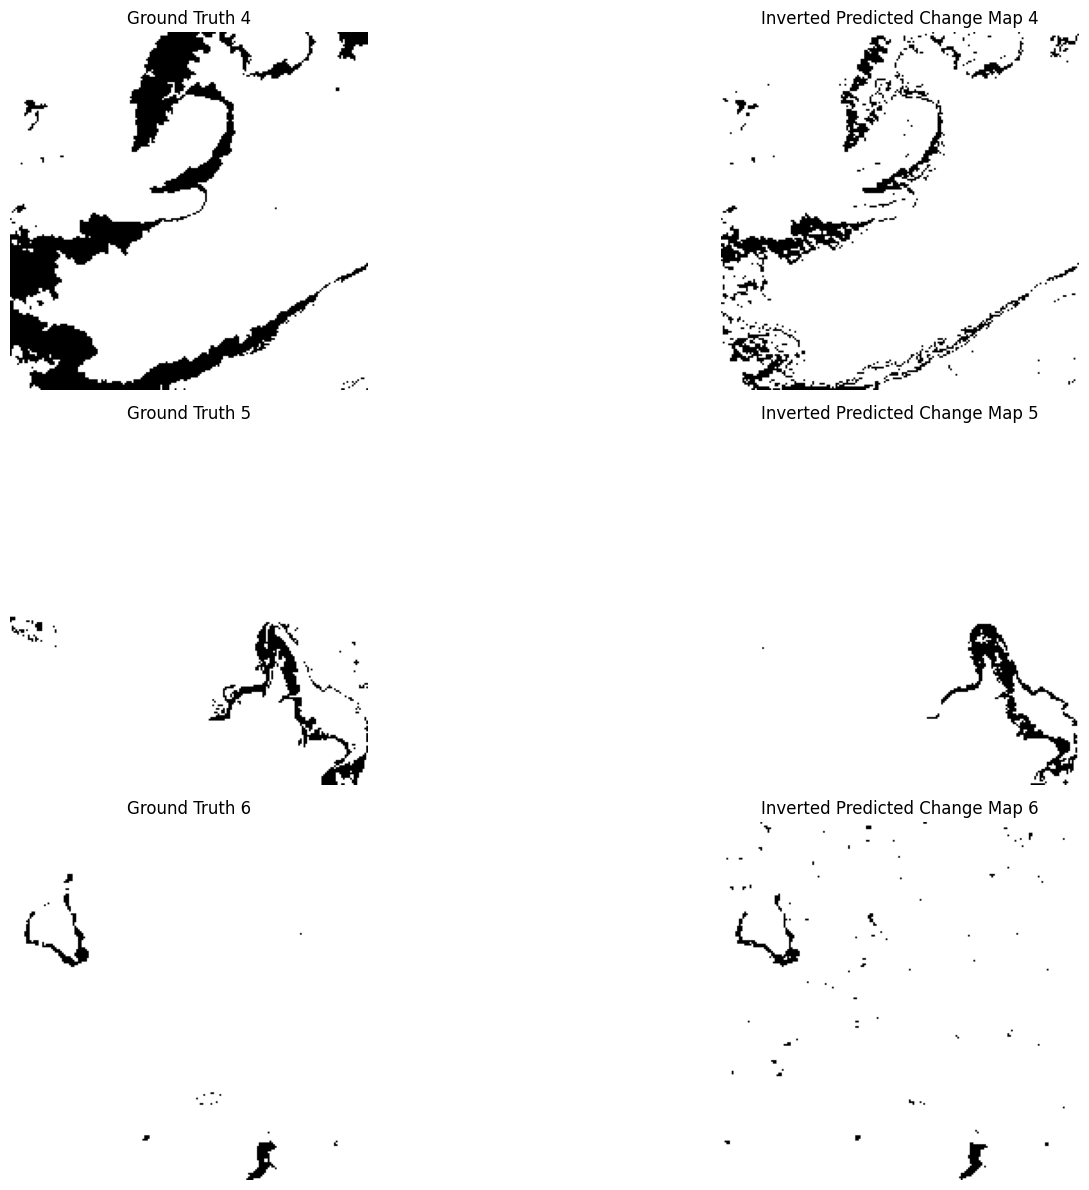

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

# Function to calculate PCC, PFA, and other metrics
def calculate_metrics(y_true, y_pred):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if cm.size == 4:  # Ensure it's a binary classification confusion matrix
        TN, FP, FN, TP = cm.ravel()

        # Invert the confusion matrix for opposite labels
        # Since predicted and ground truth are opposite
        TN, FP, FN, TP = FP, TN, TP, FN

        # Calculate metrics
        N0 = TP + FN  # Total number of actual "change" pixels
        N1 = TN + FP  # Total number of actual "no-change" pixels

        # Probabilistic Conditional Correctness (PCC)
        PCC = ((TP + TN) / (N0 + N1)) * 100 if (N0 + N1) != 0 else 0

        # Probability of False Alarm (PFA)
        PFA = FP / N1 if N1 != 0 else 0

        # Total Error (TE)
        PTE = (FN + FP) / (N0 + N1) if (N0 + N1) != 0 else 0

        return PCC, PFA, PTE
    else:
        raise ValueError("Confusion matrix size is not 4. Ensure binary classification.")

# Initialize lists for storing results
accuracies = []
y_true_list = []
y_pred_list = []

# Flatten predictions and ground truths for the test set
for idx, ground_truth in enumerate(ground_truths):
    gt_flat = ground_truth.flatten()
    predicted_map_flat = predicted_maps[idx * ground_truth.size:(idx + 1) * ground_truth.size].flatten()

    # Ensure binary classification
    y_true = np.where(gt_flat > 0.5, 1, 0)  # Convert to binary
    y_pred = np.where(predicted_map_flat > 0.5, 1, 0)  # Convert to binary

    # Calculate PCC, PFA, and PTE
    PCC, PFA, PTE = calculate_metrics(y_true, y_pred)

    # Calculate accuracy for the fold
    accuracy = accuracy_score(y_true, y_pred)
    accuracies.append(accuracy)
    y_true_list.append(y_true)
    y_pred_list.append(y_pred)
    accuracy = 1-accuracy

    # Print per dataset metrics
    print(f"Dataset {idx + 4} Metrics:")
    print(f"PCC: {PCC}%")
    print(f"PFA: {PFA}")
    print(f"PTE: {PTE}")
    print(f"Accuracy: {accuracy * 100}%")
    print("-" * 50)

# Print overall performance across all datasets
all_true = np.concatenate(y_true_list)
all_pred = np.concatenate(y_pred_list)

# Calculate confusion matrix and metrics for all datasets
cm_all = confusion_matrix(all_true, all_pred)
TN_all, FP_all, FN_all, TP_all = cm_all.ravel()

N0_all = TP_all + FN_all
N1_all = TN_all + FP_all

# Probabilistic Conditional Correctness (PCC)
PCC_all = ((TP_all + TN_all) / (N0_all + N1_all)) * 100 if (N0_all + N1_all) != 0 else 0

# Probability of False Alarm (PFA)
PFA_all = FP_all / N1_all if N1_all != 0 else 0

# Probability of Total Error (PTE)
PTE_all = (FN_all + FP_all) / (N0_all + N1_all) if (N0_all + N1_all) != 0 else 0

# Print final performance
print(f'Final Accuracy (across all datasets): {(1-np.mean(accuracies)) * 100}%')
print(f'Confusion Matrix (all datasets):\n{cm_all}')
print(f'Correct Classification (CC) across all datasets: {sum(all_true == all_pred)}')
print(f'False Alarms (FA) across all datasets: {sum(all_pred == 1) - sum(all_true == 1)}')
print(f'Total Error (TE) across all datasets: {sum(all_true != all_pred)}')
print(f'Probabilistic Conditional Correctness (PCC) across all datasets: {PCC_all}%')
print(f'Probability of False Alarm (PFA) across all datasets: {PFA_all}')
print(f'Probability of Total Error (PTE) across all datasets: {PTE_all}')

# Visualization of ground truth and predicted maps for each dataset
plt.figure(figsize=(18, 12))
for idx, ground_truth in enumerate(ground_truths):
    # Plot Ground Truth
    plt.subplot(len(ground_truths), 2, 2 * idx + 1)
    plt.imshow(ground_truth, cmap='gray')
    plt.title(f"Ground Truth {idx + 4}")
    plt.axis("off")

    # Plot Predicted Map
    predicted_map = predicted_maps[idx * ground_truth.size:(idx + 1) * ground_truth.size].reshape(ground_truth.shape)

    # Invert the predicted map to show the opposite
    inverted_predicted_map = 1 - predicted_map

    plt.subplot(len(ground_truths), 2, 2 * idx + 2)
    plt.imshow(inverted_predicted_map, cmap='gray')
    plt.title(f"Inverted Predicted Change Map {idx + 4}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# Assuming 'predicted_map' is the output of your model (predictions as probabilities)
# and 'predicted_map_flat' are the thresholded (binary) predictions
# You can invert the predictions like so:

# Inverting the predictions
inverted_pred = 1 - predicted_map_flat  # If predicted was 1 (change), it becomes 0 (no-change), and vice versa

# Now calculate confusion matrix and other metrics again using the inverted predictions
cm_inverted = confusion_matrix(y_true, inverted_pred)
TN_inverted, FP_inverted, FN_inverted, TP_inverted = cm_inverted.ravel()

# Calculate Accuracy (after inversion)
accuracy_inverted = (TP_inverted + TN_inverted) / (TP_inverted + TN_inverted + FP_inverted + FN_inverted) * 100

# Recalculate PCC, PFA, and PTE
N0_inverted = TP_inverted + FN_inverted  # Total of no-change class (after inversion)
N1_inverted = TN_inverted + FP_inverted  # Total of change class (after inversion)
PCC_inverted = ((TP_inverted + TN_inverted) / (N0_inverted + N1_inverted)) * 100 if (N0_inverted + N1_inverted) != 0 else 0

PFA_inverted = FP_inverted / N1_inverted if N1_inverted != 0 else 0

PTE_inverted = (FN_inverted + FP_inverted) / (N0_inverted + N1_inverted) if (N0_inverted + N1_inverted) != 0 else 0

# Print inverted metrics
print(f'Accuracy (Inverted): {accuracy_inverted}%')
print(f'PCC (Inverted): {PCC_inverted}%')
print(f'PFA (Inverted): {PFA_inverted}')
print(f'PTE (Inverted): {PTE_inverted}')


Accuracy (Inverted): 96.635%
PCC (Inverted): 96.635%
PFA (Inverted): 0.2175925925925926
PTE (Inverted): 0.03365


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1495: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (240, 5, 5, 2) (2 channels).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (240, 5, 5, 2) (2 channels).
  warnings.warn(


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 385ms/step - accuracy: 0.5666 - loss: 1.3732 - val_accuracy: 0.8667 - val_loss: 0.5606
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8804 - loss: 0.4696 - val_accuracy: 0.9333 - val_loss: 0.2663
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8578 - loss: 0.3321 - val_accuracy: 0.9500 - val_loss: 0.2227
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8859 - loss: 0.2841 - val_accuracy: 0.9500 - val_loss: 0.1681
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8486 - loss: 0.3349 - val_accuracy: 0.9500 - val_loss: 0.2120
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8752 - loss: 0.2800 - val_accuracy: 0.9167 - val_loss: 0.2655
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9011 - loss: 0.2678 - val_accuracy: 0.8667 - val_loss: 0.2940
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9287 - loss: 0.2602 - val_accuracy: 0.9500 - val_loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1495: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (240, 5, 5, 2) (2 channels).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (240, 5, 5, 2) (2 channels).
  warnings.warn(


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.4917 - loss: 0.7761 - val_accuracy: 0.6167 - val_loss: 0.6923
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6127 - loss: 0.6906 - val_accuracy: 0.5500 - val_loss: 0.6836
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6548 - loss: 0.6778 - val_accuracy: 0.4500 - val_loss: 0.6669
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4952 - loss: 0.6375 - val_accuracy: 0.6000 - val_loss: 0.6914
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5170 - loss: 0.6911 - val_accuracy: 0.6000 - val_loss: 0.7032
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6474 - loss: 0.6890 - val_accuracy: 0.7500 - val_loss: 0.7117
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6045 - loss: 0.6433 - val_accuracy: 0.4833 - val_loss: 0.8336
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5882 - loss: 0.6675 - val_accuracy: 0.4333 - val_loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1495: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (240, 5, 5, 2) (2 channels).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (240, 5, 5, 2) (2 channels).
  warnings.warn(


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.4795 - loss: 0.9012 - val_accuracy: 0.5167 - val_loss: 0.6896
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.4735 - loss: 0.6928 - val_accuracy: 0.5167 - val_loss: 0.6870
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5638 - loss: 0.6810 - val_accuracy: 0.8167 - val_loss: 0.5983
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8373 - loss: 0.5028 - val_accuracy: 0.8500 - val_loss: 0.4339
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8983 - loss: 0.2946 - val_accuracy: 0.8167 - val_loss: 0.4416
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8047 - loss: 0.4252 - val_accuracy: 0.7667 - val_loss: 0.4659
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8998 - loss: 0.2801 - val_accuracy: 0.8833 - val_loss: 0.3998
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9227 - loss: 0.2123 - val_accuracy: 0.8667 - val_loss: 

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 903ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1495: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (240, 5, 5, 2) (2 channels).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (240, 5, 5, 2) (2 channels).
  warnings.warn(


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.5775 - loss: 0.7272 - val_accuracy: 0.8833 - val_loss: 0.5083
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8042 - loss: 0.4356 - val_accuracy: 0.9000 - val_loss: 0.3549
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8701 - loss: 0.3518 - val_accuracy: 0.9333 - val_loss: 0.1730
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9077 - loss: 0.2355 - val_accuracy: 0.9667 - val_loss: 0.1509
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8709 - loss: 0.3116 - val_accuracy: 0.9500 - val_loss: 0.1955
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8908 - loss: 0.2634 - val_accuracy: 0.9333 - val_loss: 0.2101
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8770 - loss: 0.3514 - val_accuracy: 0.9667 - val_loss: 0.1249
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9372 - loss: 0.1783 - val_accuracy: 0.9667 - val_loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1495: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (240, 5, 5, 2) (2 channels).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (240, 5, 5, 2) (2 channels).
  warnings.warn(


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.5745 - loss: 0.7081 - val_accuracy: 0.5500 - val_loss: 0.6386
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6995 - loss: 0.5696 - val_accuracy: 0.7333 - val_loss: 0.5777
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8089 - loss: 0.4093 - val_accuracy: 0.9000 - val_loss: 0.3867
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8093 - loss: 0.4017 - val_accuracy: 0.9000 - val_loss: 0.2500
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8537 - loss: 0.2922 - val_accuracy: 0.9333 - val_loss: 0.2287
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8834 - loss: 0.2560 - val_accuracy: 0.9167 - val_loss: 0.2313
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8217 - loss: 0.4402 - val_accuracy: 0.9167 - val_loss: 0.4246
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8893 - loss: 0.4083 - val_accuracy: 0.8667 - val_loss: 

ValueError: operands could not be broadcast together with shapes (10,10) (100,) 

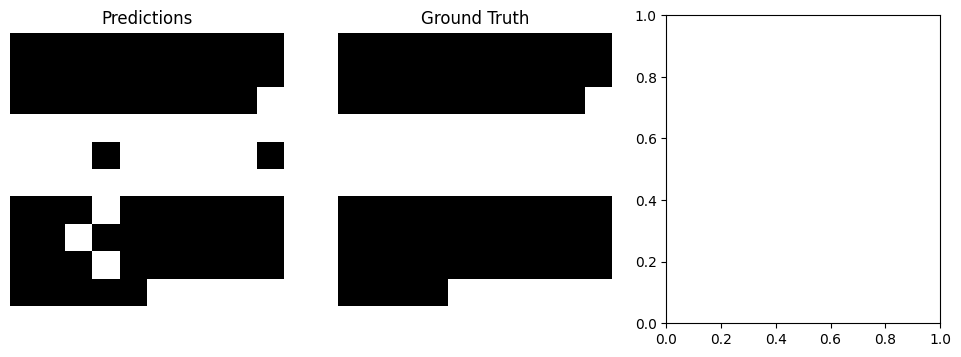

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dense, Flatten, Lambda, Multiply, Add
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load images
image1 = cv2.imread('/content/set11.tif', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('/content/set12.tif', cv2.IMREAD_GRAYSCALE)
ground_truth = cv2.imread('/content/gt1.tif', cv2.IMREAD_GRAYSCALE)

# Pad images and check if images are loaded properly
pad_width = 2
image1_padded = np.pad(image1, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant')
image2_padded = np.pad(image2, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant')

# Function to get neighborhood
def get_neighbourhood(image_padded, i, j):
    return image_padded[i - pad_width:i + pad_width + 1, j - pad_width:j + pad_width + 1].reshape(5, 5, 1)

# Prepare data
data = []
labels = []
for i in range(pad_width, image1_padded.shape[0] - pad_width):
    for j in range(pad_width, image1_padded.shape[1] - pad_width):
        neighbourhood1 = get_neighbourhood(image1_padded, i, j)
        neighbourhood2 = get_neighbourhood(image2_padded, i, j)
        data.append(np.dstack((neighbourhood1, neighbourhood2)))  # Stack the two neighborhoods

# Convert data to numpy array
data = np.array(data)

# Get change locations from ground truth
change_indices = np.argwhere(ground_truth == 0)
unchanged_indices = np.argwhere(ground_truth != 0)

# Ensure we have enough samples
if len(change_indices) < 150 or len(unchanged_indices) < 150:
    raise ValueError("Not enough change or unchanged locations in the ground truth image.")

# Randomly select 150 change and unchanged locations
selected_change_indices = np.random.choice(len(change_indices), size=150, replace=False)
selected_unchanged_indices = np.random.choice(len(unchanged_indices), size=150, replace=False)

# Extract samples and labels
change_samples = [data[(i - pad_width) * (image1_padded.shape[1] - 2 * pad_width) + (j - pad_width)] for i, j in change_indices[selected_change_indices]]
unchanged_samples = [data[(i - pad_width) * (image1_padded.shape[1] - 2 * pad_width) + (j - pad_width)] for i, j in unchanged_indices[selected_unchanged_indices]]

change_labels = [0] * 150
unchanged_labels = [1] * 150

# Combine data
X = np.array(change_samples + unchanged_samples)
y = np.array(change_labels + unchanged_labels)

# Reshape y to be a 1D array for binary classification
y = y.reshape(-1)

# Cross-validation setup using KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Define U-Net with Attention model
def attention_gate(x, g, inter_channels):
    theta_x = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(x)
    phi_g = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(g)
    add_xg = Add()([theta_x, phi_g])
    relu_xg = tf.keras.layers.Activation('relu')(add_xg)
    psi = Conv2D(1, kernel_size=1, strides=1, padding='same', activation='sigmoid')(relu_xg)
    return Multiply()([x, psi])

def unet_with_attention(input_shape=(5, 5, 2)):
    inputs = Input(input_shape)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((1, 1))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((1, 1))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)

    aspp_1 = Conv2D(256, (3, 3), dilation_rate=1, activation='relu', padding='same')(conv4)
    aspp_2 = Conv2D(256, (3, 3), dilation_rate=2, activation='relu', padding='same')(conv4)
    aspp_3 = Conv2D(256, (3, 3), dilation_rate=4, activation='relu', padding='same')(conv4)
    aspp_4 = Conv2D(256, (3, 3), dilation_rate=8, activation='relu', padding='same')(conv4)
    aspp_out = Concatenate()([aspp_1, aspp_2, aspp_3, aspp_4])
    aspp_out = Conv2D(256, (1, 1), activation='relu', padding='same')(aspp_out)

    up5 = UpSampling2D((1, 1))(aspp_out)
    att5 = attention_gate(conv3, up5, inter_channels=128)
    concat5 = Concatenate()([up5, att5])
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    up6 = UpSampling2D((1, 1))(conv5)
    att6 = attention_gate(conv2, up6, inter_channels=64)
    concat6 = Concatenate()([up6, att6])
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D((1, 1))(conv6)
    att7 = attention_gate(conv1, up7, inter_channels=32)
    concat7 = Concatenate()([up7, att7])
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)

    output = Flatten()(conv7)
    output = Dense(1, activation='sigmoid')(output)
    model = Model(inputs, output)
    return model

# Cross-validation loop
accuracies = []
y_true_list = []
y_pred_list = []
for train_index, val_index in kf.split(X):
    # Split data into train and validation based on current fold
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Data augmentation (can be added to your training loop)
    datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)
    datagen.fit(X_train_fold)

    # Create and compile the model for each fold
    model = unet_with_attention(input_shape=(5, 5, 2))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(datagen.flow(X_train_fold, y_train_fold, batch_size=16), epochs=20, validation_data=(X_val_fold, y_val_fold))

    # Predict and evaluate
    y_pred_fold = model.predict(X_val_fold)
    y_pred_classes_fold = (y_pred_fold > 0.5).astype(int).flatten()

    # Calculate confusion matrix
    cm = confusion_matrix(y_val_fold, y_pred_classes_fold)
    TN, FP, FN, TP = cm.ravel()

    # Calculate metrics
    N0 = TP + FN
    N1 = TN + FP
    PCC = ((TP + TN) / (N0 + N1)) * 100 if (N0 + N1) != 0 else 0
    PFA = FP / N1 if N1 != 0 else 0
    PTE = (FN + FP) / (N0 + N1) if (N0 + N1) != 0 else 0

    accuracies.append(accuracy_score(y_val_fold, y_pred_classes_fold))
    y_true_list.append(y_val_fold)
    y_pred_list.append(y_pred_classes_fold)

# Print final performance after all folds
print(f'Fold Accuracy: {np.mean(accuracies)}')
print(f'Confusion Matrix: {confusion_matrix(np.concatenate(y_true_list), np.concatenate(y_pred_list))}')
print(f'Correct Classification (CC): {sum(np.concatenate(y_true_list) == np.concatenate(y_pred_list))}')
print(f'False Alarms (FA): {sum(np.concatenate(y_pred_list) == 1) - sum(np.concatenate(y_true_list) == 1)}')
print(f'Total Error (TE): {sum(np.concatenate(y_true_list) != np.concatenate(y_pred_list))}')
print(f'Probabilistic Conditional Correctness (PCC): {PCC}')
print(f'Probability of False Alarm (PFA): {PFA}')
print(f'Probability of Total Error (PTE): {PTE}')

# Plotting comparison of prediction and ground truth once at the end
plt.figure(figsize=(12, 4))

# Display a sample of predictions vs ground truth
plt.subplot(1, 3, 1)
plt.imshow(np.concatenate(y_pred_list)[:100].reshape(10, 10), cmap='gray')  # Prediction
plt.title("Predictions")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(np.concatenate(y_true_list)[:100].reshape(10, 10), cmap='gray')  # Ground truth
plt.title("Ground Truth")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(np.concatenate(y_true_list)[:100].reshape(10, 10) == np.concatenate(y_pred_list)[:100], cmap='gray')
plt.title("Correctly Classified")
plt.axis('off')

plt.show()


Epoch 1/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.9739 - loss: 0.0872
Epoch 2/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9846 - loss: 0.0508
Epoch 3/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9860 - loss: 0.0471
Epoch 4/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9868 - loss: 0.0440
Epoch 5/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9875 - loss: 0.0425
Epoch 6/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9878 - loss: 0.0408
Epoch 7/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9878 - loss: 0.0401
Epoch 8/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9883 - loss: 0.0384
Epoch 9/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9881 - loss: 0.0390
Epoch 10/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9884 - loss: 0.0387
6263/6263 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


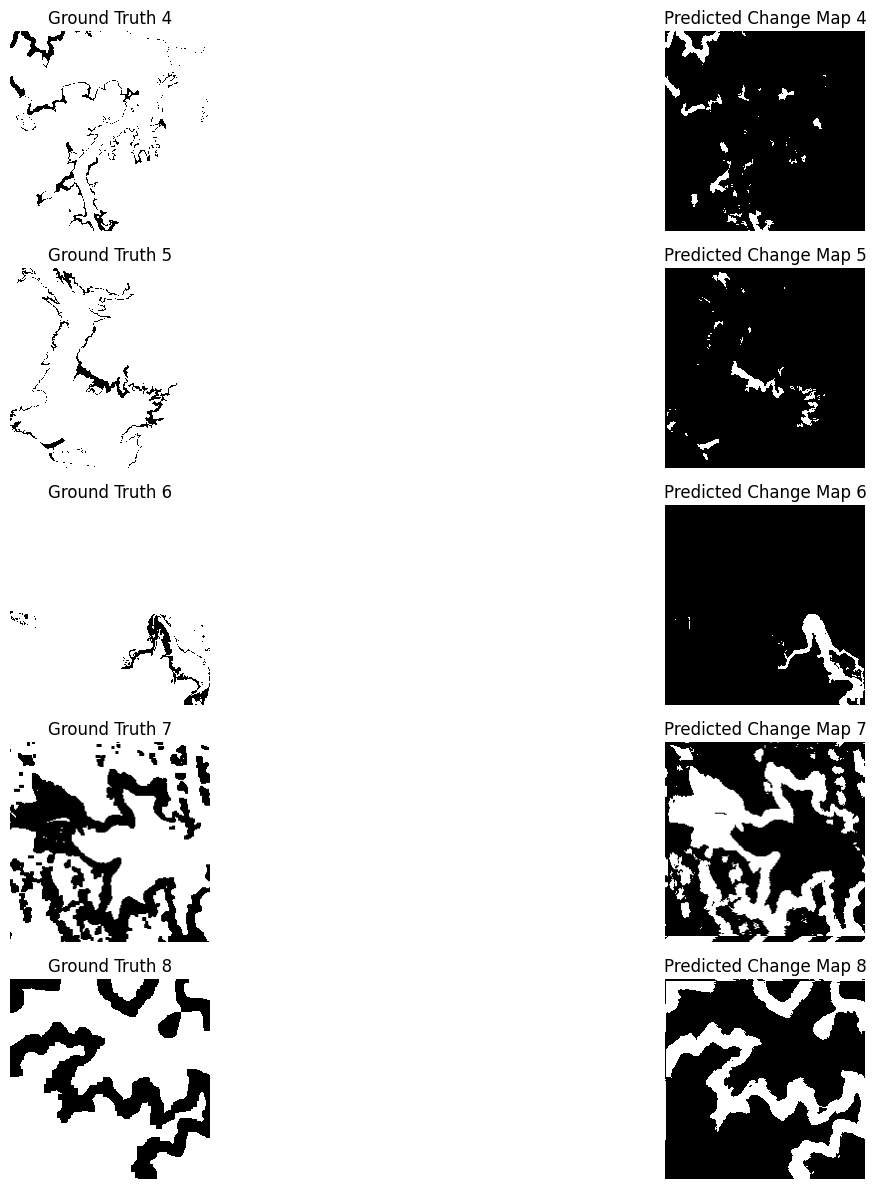

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dense, Flatten

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load and pad images
def load_and_pad_image(filepath, pad_width):
    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    return np.pad(image, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant')

# Extract neighborhood
def get_neighbourhood(image_padded, i, j, pad_width):
    return image_padded[i - pad_width:i + pad_width + 1, j - pad_width:j + pad_width + 1].reshape(5, 5, 1)

# Prepare dataset
def prepare_data(image1, image2, ground_truth, pad_width):
    image1_padded = load_and_pad_image(image1, pad_width)
    image2_padded = load_and_pad_image(image2, pad_width)
    ground_truth = cv2.imread(ground_truth, cv2.IMREAD_GRAYSCALE)

    data, labels = [], []
    for i in range(pad_width, image1_padded.shape[0] - pad_width):
        for j in range(pad_width, image1_padded.shape[1] - pad_width):
            neighbourhood1 = get_neighbourhood(image1_padded, i, j, pad_width)
            neighbourhood2 = get_neighbourhood(image2_padded, i, j, pad_width)
            data.append(np.dstack((neighbourhood1, neighbourhood2)))
            labels.append(1 if ground_truth[i - pad_width, j - pad_width] == 0 else 0)

    return np.array(data), np.array(labels), ground_truth

# Define U-Net model
def unet(input_shape=(5, 5, 2)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((1, 1))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((1, 1))(conv2)

    # Bottleneck
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

    # Decoder
    up4 = UpSampling2D((1, 1))(conv3)
    concat4 = Concatenate()([up4, conv2])
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

    up5 = UpSampling2D((1, 1))(conv4)
    concat5 = Concatenate()([up5, conv1])
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)

    output = Flatten()(conv5)
    output = Dense(1, activation='sigmoid')(output)

    model = Model(inputs, output)
    return model

# Dataset paths
datasets = [
    ("/content/set11.tif", "/content/set12.tif", "/content/gt1.tif"),
    ("/content/set21.tif", "/content/set22.tif", "/content/gt2.tif"),
    ("/content/set31.tif", "/content/set32.tif", "/content/gt3.tif"),
    ("/content/set41.tif", "/content/set42.tif", "/content/gt4.tif"),
    ("/content/set51.tif", "/content/set52.tif", "/content/gt5.tif"),
    ("/content/set61.tif", "/content/set62.tif", "/content/gt6.tif"),
    ("/content/set71.TIF", "/content/set72.TIF", "/content/gt7.TIF"),
    ("/content/set81.TIF", "/content/set82.TIF", "/content/gt8.TIF"),
    ("/content/set91.TIF", "/content/set92.TIF", "/content/gt9.TIF")
]

# Train-Test Split
train_datasets = [datasets[i] for i in [1,3,5,7]]
test_datasets = [datasets[i] for i in [0,2,4,6,8]]


# Prepare training data
pad_width = 2
X_train, y_train = [], []

for img1, img2, gt in train_datasets:
    data, labels, _ = prepare_data(img1, img2, gt, pad_width)
    X_train.append(data)
    y_train.append(labels)

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

# Prepare testing data
X_test, y_test, ground_truths = [], [], []

for img1, img2, gt in test_datasets:
    data, labels, ground_truth = prepare_data(img1, img2, gt, pad_width)
    X_test.append(data)
    y_test.append(labels)
    ground_truths.append(ground_truth)

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

# Build & Train Model
model = unet(input_shape=(5, 5, 2))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Predict on test data
predictions = model.predict(X_test)
predicted_maps = (predictions > 0.5).astype(int)

# Visualization
plt.figure(figsize=(18, 12))
for idx, gt in enumerate(ground_truths):
    plt.subplot(len(ground_truths), 2, 2 * idx + 1)
    plt.imshow(gt, cmap='gray')
    plt.title(f"Ground Truth {idx + 4}")
    plt.axis("off")

    predicted_map = predicted_maps[idx * gt.size:(idx + 1) * gt.size].reshape(gt.shape)
    plt.subplot(len(ground_truths), 2, 2 * idx + 2)
    plt.imshow(predicted_map, cmap='gray')
    plt.title(f"Predicted Change Map {idx + 4}")
    plt.axis("off")

plt.tight_layout()
plt.show()


Epoch 1/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.9763 - loss: 0.0710
Epoch 2/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.9855 - loss: 0.0471
Epoch 3/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9870 - loss: 0.0423
Epoch 4/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.9874 - loss: 0.0398
Epoch 5/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9885 - loss: 0.0372
Epoch 6/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.9886 - loss: 0.0358
Epoch 7/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.9892 - loss: 0.0339
Epoch 8/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.9893 - loss: 0.0326
Epoch 9/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9893 - loss: 0.0326
Epoch 10/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9901 - loss: 0.0307
6263/6263 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


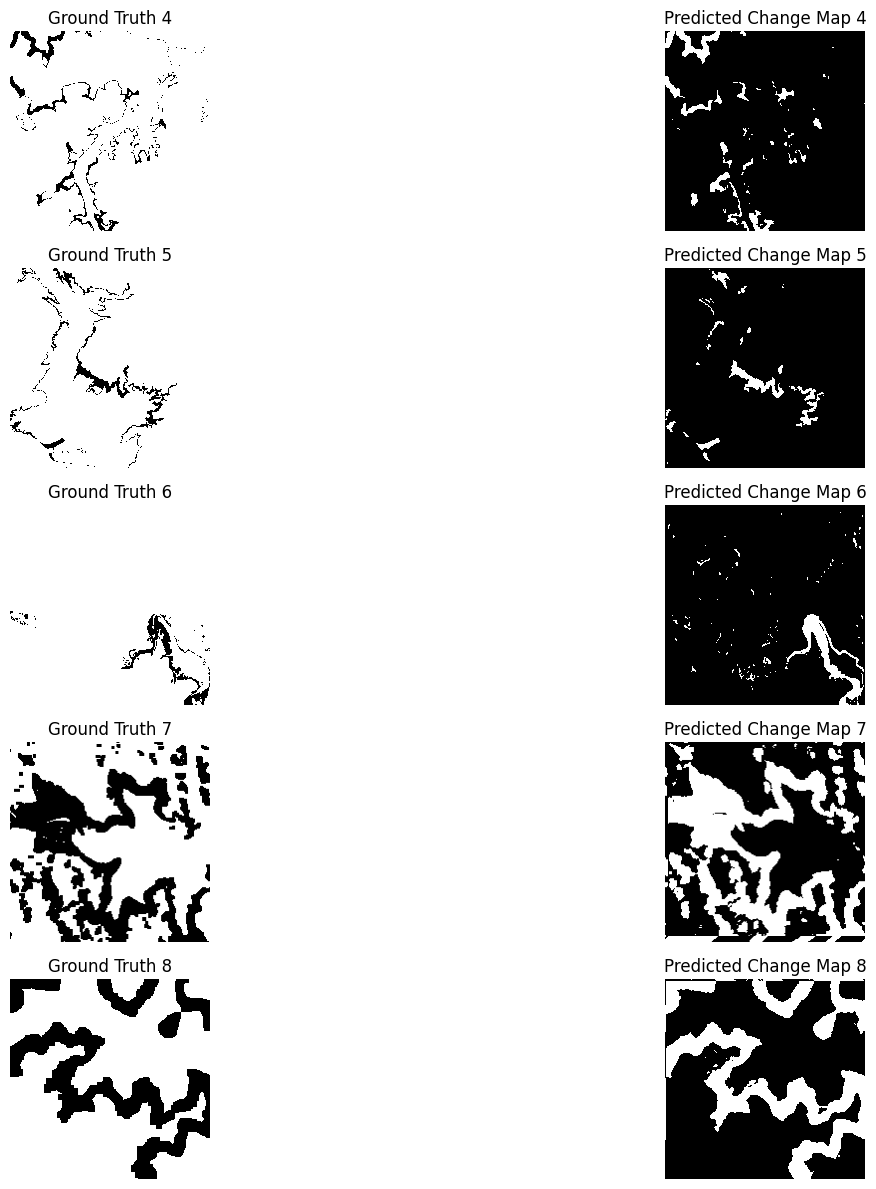

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, UpSampling2D,
                                     Concatenate, Dense, Flatten, BatchNormalization, Dropout)


# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load and pad images
def load_and_pad_image(filepath, pad_width):
    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    return np.pad(image, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant')

# Extract neighborhood
def get_neighbourhood(image_padded, i, j, pad_width):
    return image_padded[i - pad_width:i + pad_width + 1, j - pad_width:j + pad_width + 1]  # Shape (5,5)

# Prepare dataset
def prepare_data(image1, image2, ground_truth, pad_width):
    image1_padded = load_and_pad_image(image1, pad_width)
    image2_padded = load_and_pad_image(image2, pad_width)
    ground_truth = cv2.imread(ground_truth, cv2.IMREAD_GRAYSCALE)

    data, labels = [], []
    for i in range(pad_width, image1_padded.shape[0] - pad_width):
        for j in range(pad_width, image1_padded.shape[1] - pad_width):
            neighbourhood1 = get_neighbourhood(image1_padded, i, j, pad_width)
            neighbourhood2 = get_neighbourhood(image2_padded, i, j, pad_width)
            stacked_data = np.stack((neighbourhood1, neighbourhood2), axis=-1)  # Shape (5,5,2)
            data.append(stacked_data)
            labels.append(1 if ground_truth[i - pad_width, j - pad_width] == 0 else 0)

    return np.array(data), np.array(labels), ground_truth

# Define U-Net model
def unet(input_shape=(5, 5, 2)):  # Ensure consistency with new reshaped data
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = Dropout(0.2)(conv1)
    pool1 = MaxPooling2D((1, 1))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = Dropout(0.3)(conv2)
    pool2 = MaxPooling2D((1, 1))(conv2)

    # Bottleneck
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = Dropout(0.4)(conv3)

    # Decoder
    up4 = UpSampling2D((1, 1))(conv3)
    concat4 = Concatenate()([up4, conv2])
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

    up5 = UpSampling2D((1, 1))(conv4)
    concat5 = Concatenate()([up5, conv1])
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)

    output = Flatten()(conv5)
    output = Dense(1, activation='sigmoid')(output)

    model = Model(inputs, output)
    return model


# Dataset paths
datasets = [
    ("/content/set11.tif", "/content/set12.tif", "/content/gt1.tif"),
    ("/content/set21.tif", "/content/set22.tif", "/content/gt2.tif"),
    ("/content/set31.tif", "/content/set32.tif", "/content/gt3.tif"),
    ("/content/set41.tif", "/content/set42.tif", "/content/gt4.tif"),
    ("/content/set51.tif", "/content/set52.tif", "/content/gt5.tif"),
    ("/content/set61.tif", "/content/set62.tif", "/content/gt6.tif"),
    ("/content/set71.TIF", "/content/set72.TIF", "/content/gt7.TIF"),
    ("/content/set81.TIF", "/content/set82.TIF", "/content/gt8.TIF"),
    ("/content/set91.TIF", "/content/set92.TIF", "/content/gt9.TIF")
]

# Train-Test Split
train_datasets = [datasets[i] for i in [1,3,5,7]]
test_datasets = [datasets[i] for i in [0,2,4,6,8]]

# Prepare training data
pad_width = 2
X_train, y_train = [], []

for img1, img2, gt in train_datasets:
    data, labels, _ = prepare_data(img1, img2, gt, pad_width)
    X_train.append(data)
    y_train.append(labels)

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

# Prepare testing data
X_test, y_test, ground_truths = [], [], []

for img1, img2, gt in test_datasets:
    data, labels, ground_truth = prepare_data(img1, img2, gt, pad_width)
    X_test.append(data)
    y_test.append(labels)
    ground_truths.append(ground_truth)

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

# Build & Train Model
model = unet(input_shape=(5, 5, 2))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Predict on test data
predictions = model.predict(X_test)
predicted_maps = (predictions > 0.5).astype(int)

# Visualization
plt.figure(figsize=(18, 12))
for idx, gt in enumerate(ground_truths):
    plt.subplot(len(ground_truths), 2, 2 * idx + 1)
    plt.imshow(gt, cmap='gray')
    plt.title(f"Ground Truth {idx + 4}")
    plt.axis("off")

    predicted_map = predicted_maps[idx * gt.size:(idx + 1) * gt.size].reshape(gt.shape)
    plt.subplot(len(ground_truths), 2, 2 * idx + 2)
    plt.imshow(predicted_map, cmap='gray')
    plt.title(f"Predicted Change Map {idx + 4}")
    plt.axis("off")

plt.tight_layout()
plt.show()


Dataset 1 Metrics:
PCC: 97.005%
PFA: 0.2774018944519621
PTE: 0.02995
Accuracy: 97.005%
--------------------------------------------------
Dataset 2 Metrics:
PCC: 97.495%
PFA: 0.3561924257932446
PTE: 0.02505
Accuracy: 97.495%
--------------------------------------------------
Dataset 3 Metrics:
PCC: 97.48%
PFA: 0.21382636655948553
PTE: 0.0252
Accuracy: 97.48%
--------------------------------------------------
Dataset 4 Metrics:
PCC: 71.93633820945026%
PFA: 0.34982549784438516
PTE: 0.2806366179054974
Accuracy: 71.93633820945027%
--------------------------------------------------
Dataset 5 Metrics:
PCC: 94.635%
PFA: 0.11196911196911197
PTE: 0.05365
Accuracy: 94.635%
--------------------------------------------------
Final Accuracy (across all datasets): 91.71026764189006%
Confusion Matrix (all datasets):
[[  7965  23459]
 [160250   8727]]
Correct Classification (CC) across all datasets: 16692
False Alarms (FA) across all datasets: -136791
Total Error (TE) across all datasets: 183709
Proba

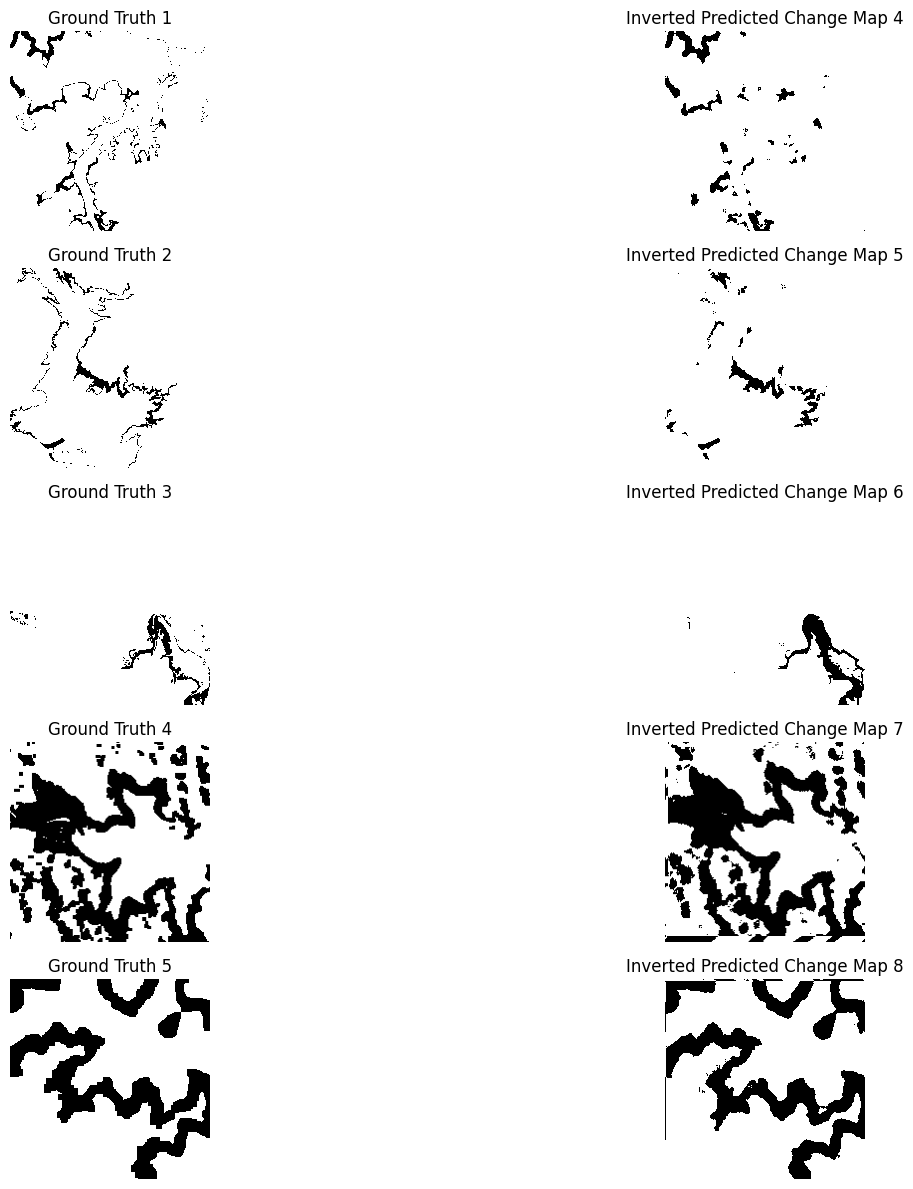

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

# Function to calculate PCC, PFA, and other metrics
def calculate_metrics(y_true, y_pred):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if cm.size == 4:  # Ensure it's a binary classification confusion matrix
        TN, FP, FN, TP = cm.ravel()

        # Invert the confusion matrix for opposite labels
        # Since predicted and ground truth are opposite
        TN, FP, FN, TP = FP, TN, TP, FN

        # Calculate metrics
        N0 = TP + FN  # Total number of actual "change" pixels
        N1 = TN + FP  # Total number of actual "no-change" pixels

        # Probabilistic Conditional Correctness (PCC)
        PCC = ((TP + TN) / (N0 + N1)) * 100 if (N0 + N1) != 0 else 0

        # Probability of False Alarm (PFA)
        PFA = FP / N1 if N1 != 0 else 0

        # Total Error (TE)
        PTE = (FN + FP) / (N0 + N1) if (N0 + N1) != 0 else 0

        return PCC, PFA, PTE
    else:
        raise ValueError("Confusion matrix size is not 4. Ensure binary classification.")

# Initialize lists for storing results
accuracies = []
y_true_list = []
y_pred_list = []

# Flatten predictions and ground truths for the test set
for idx, ground_truth in enumerate(ground_truths):
    gt_flat = ground_truth.flatten()
    predicted_map_flat = predicted_maps[idx * ground_truth.size:(idx + 1) * ground_truth.size].flatten()

    # Ensure binary classification
    y_true = np.where(gt_flat > 0.5, 1, 0)  # Convert to binary
    y_pred = np.where(predicted_map_flat > 0.5, 1, 0)  # Convert to binary

    # Calculate PCC, PFA, and PTE
    PCC, PFA, PTE = calculate_metrics(y_true, y_pred)

    # Calculate accuracy for the fold
    accuracy = accuracy_score(y_true, y_pred)
    accuracies.append(accuracy)
    y_true_list.append(y_true)
    y_pred_list.append(y_pred)
    accuracy = 1-accuracy

    # Print per dataset metrics
    print(f"Dataset {idx + 1} Metrics:")
    print(f"PCC: {PCC}%")
    print(f"PFA: {PFA}")
    print(f"PTE: {PTE}")
    print(f"Accuracy: {accuracy * 100}%")
    print("-" * 50)

# Print overall performance across all datasets
all_true = np.concatenate(y_true_list)
all_pred = np.concatenate(y_pred_list)

# Calculate confusion matrix and metrics for all datasets
cm_all = confusion_matrix(all_true, all_pred)
TN_all, FP_all, FN_all, TP_all = cm_all.ravel()

N0_all = TP_all + FN_all
N1_all = TN_all + FP_all

# Probabilistic Conditional Correctness (PCC)
PCC_all = ((TP_all + TN_all) / (N0_all + N1_all)) * 100 if (N0_all + N1_all) != 0 else 0

# Probability of False Alarm (PFA)
PFA_all = FP_all / N1_all if N1_all != 0 else 0

# Probability of Total Error (PTE)
PTE_all = (FN_all + FP_all) / (N0_all + N1_all) if (N0_all + N1_all) != 0 else 0

# Print final performance
print(f'Final Accuracy (across all datasets): {(1-np.mean(accuracies)) * 100}%')
print(f'Confusion Matrix (all datasets):\n{cm_all}')
print(f'Correct Classification (CC) across all datasets: {sum(all_true == all_pred)}')
print(f'False Alarms (FA) across all datasets: {sum(all_pred == 1) - sum(all_true == 1)}')
print(f'Total Error (TE) across all datasets: {sum(all_true != all_pred)}')
print(f'Probabilistic Conditional Correctness (PCC) across all datasets: {PCC_all}%')
print(f'Probability of False Alarm (PFA) across all datasets: {PFA_all}')
print(f'Probability of Total Error (PTE) across all datasets: {PTE_all}')

# Visualization of ground truth and predicted maps for each dataset
plt.figure(figsize=(18, 12))
for idx, ground_truth in enumerate(ground_truths):
    # Plot Ground Truth
    plt.subplot(len(ground_truths), 2, 2 * idx + 1)
    plt.imshow(ground_truth, cmap='gray')
    plt.title(f"Ground Truth {idx + 1}")
    plt.axis("off")

    # Plot Predicted Map
    predicted_map = predicted_maps[idx * ground_truth.size:(idx + 1) * ground_truth.size].reshape(ground_truth.shape)

    # Invert the predicted map to show the opposite
    inverted_predicted_map = 1 - predicted_map

    plt.subplot(len(ground_truths), 2, 2 * idx + 2)
    plt.imshow(inverted_predicted_map, cmap='gray')
    plt.title(f"Inverted Predicted Change Map {idx + 4}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import os

dataset_path = "/content/gdrive/MyDrive/Images"  # Change this to the actual folder name

# List all datasets in the folder
datasets = os.listdir(dataset_path)
print("Available datasets:", datasets)


Available datasets: ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6', 'Set 7', 'Set 8', 'Set 9']
